# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns

!pip install phik 
from phik import phik_matrix
import os
!pip install python-dotenv
from dotenv import load_dotenv 

In [10]:
load_dotenv(dotenv_path='.env')
user = os.getenv('user')
pwd = os.getenv('pwd')
host = os.getenv('host')
port = os.getenv('port')
db = os.getenv('db')

In [11]:
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

In [3]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
engine = create_engine(connection_string)

In [5]:
query = '''
select user_id, 
device_type_canonical, 
order_id, 
created_dt_msk, 
created_ts_msk, 
currency_code, 
revenue, 
tickets_count, 

extract(day from created_dt_msk -
lag(created_dt_msk) over(partition by user_id order by created_dt_msk)) as days_since_prev, 

event_id, 
event_name_code as event_name, 
event_type_main, 
service_name, 
region_name, 
city_name
from afisha.purchases
join afisha.events using (event_id)
join afisha.city  using (city_id)
join afisha.regions using (region_id)
where device_type_canonical in ('mobile', 'desktop') and event_type_main != 'фильм'
order by user_id 
'''

In [6]:
df = pd.read_sql_query(query, con=engine)

In [7]:
df.head()

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   created_dt_msk         290611 non-null  datetime64[ns]
 4   created_ts_msk         290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

В изучаемом датасете **15** столбцов и **290611** строк. 


- Задействаованы следующие типы данных:

    - `datetime64[ns]` - 2 столбца
    
    - `float64` - 2 столбца
    
    - `int64` - 3 столбца 
    
    - `object` - 8 столбцов


- Имеются пропуски в столбце `days_since_prev`, эти пропуски подходят под тип **NAR** и говорят о том, что запись содержит инфомацию о первом заказе клиена


- Названия столбцов приведены к типу `snake_case`

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


Создадим новый столбец `revenue_rub` 

Загрузим датасет с информацией о тенге для приведения все записей о выручке к единому курсу

In [9]:
final_tickets = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [10]:
final_tickets.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [11]:
final_tickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


Обратим внимание, что в столбце `data` используется тип `object`, что может помешать в дальнейшем сравнении. Преобразуем тип данных в `datetime64`

In [12]:
final_tickets['data'] = final_tickets['data'].astype('datetime64[ns]')

In [13]:
# Создадим функцию для создания нового столбца

def kst_to_rub(row):
    if row['currency_code'] == 'kzt':
        curs = final_tickets[final_tickets['data'] == row['created_dt_msk']]['curs'].iloc[0]
        new_revenue = row['revenue'] * curs / 100
        return new_revenue
    
    return row['revenue']

In [14]:
# Создадим новый столбец с выручкой в рублях

df['revenue_rub'] = df.apply(kst_to_rub, axis=1)

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

Ранее мы рассмотрели данные на типы и пропущенные значения, заметим, что пропущенные значения встречаются в столбце `days_since_prev` и не являются ошибкой. Так же обратим внимание, что можно оптимизировать некоторые типы данных:


- атрибут `device_type_canonical` содержит информацию о типе устройств, в нем могут встретиться лишь 2 значения: `mobile` и `desktop`. Такой столбец можно привести к категориальному типу данных `category`.


- атрибут `currency_code` также может содержить лишь 2 значения: `rub` и `kzt`. Его тоже стоит привести к типу `category`.


- атрибут `tickets_count` содержит информацию о количестве купленных билетов. Это поле не может содержать слишком высокие значения. Его можно изменить на `int8`.


- атрибут `days_since_prev` содержит количество дней, прошедших с даты последнего заказа. Количество дней всегда целое. Столбцу соответствует тип `int32`.

---

Преобразуем типы данных 

In [15]:
# Преобразуем тип для device_type_canonical
df['device_type_canonical'] = df['device_type_canonical'].astype('category')

In [16]:
# Преобразуем тип для currency_code
df['currency_code'] = df['currency_code'].astype('category')

In [17]:
# Преобразуем тип для tickets_count
df['tickets_count'] = pd.to_numeric(df['tickets_count'], downcast='integer')

Для преобразования типа `days_since_prev` заменим пропущенные значения, на значение индикатор `-1`

In [18]:
# Заполним пропуски на -1
df['days_since_prev'] = df['days_since_prev'].fillna(-1)

# Преобразуем тип для days_since_prev
df['days_since_prev'] = df['days_since_prev'].astype('int32')

In [19]:
# Выведем преобразованные типы данных
df.dtypes

user_id                          object
device_type_canonical          category
order_id                          int64
created_dt_msk           datetime64[ns]
created_ts_msk           datetime64[ns]
currency_code                  category
revenue                         float64
tickets_count                      int8
days_since_prev                   int32
event_id                          int64
event_name                       object
event_type_main                  object
service_name                     object
region_name                      object
city_name                        object
revenue_rub                     float64
dtype: object

---

Изучим значения в категориальных столбцах

In [20]:
# Уникальные значения уникальных столбцов
for column in ['device_type_canonical', 'currency_code', 'event_type_main']:
    print(f'Столбец {column}: {list(df[column].unique())}')

Столбец device_type_canonical: ['mobile', 'desktop']
Столбец currency_code: ['rub', 'kzt']
Столбец event_type_main: ['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт', 'ёлки']


Посмотрим на количество уникальных значений в столбцах с названиями 

In [21]:
for column in ['service_name', 'region_name', 'city_name']:
    print(f'Кол-во уникальных значений в столбце {column}: {df[column].nunique()}')

Кол-во уникальных значений в столбце service_name: 36
Кол-во уникальных значений в столбце region_name: 81
Кол-во уникальных значений в столбце city_name: 352


В данных встречается 36 сервисов, 81 регион и 352 города

---

###### Проверим распределение численных данных и наличие в них выбросов.

Text(0.5, 1.0, 'Диаграммма размаха по revenue_rub')

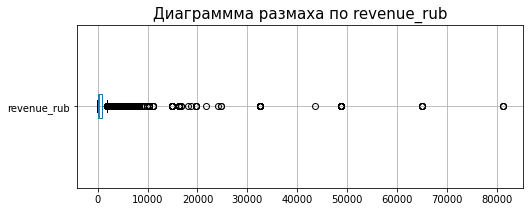

In [22]:
# Посмотрим распредение данных в столбце revenue_rub
df.boxplot(column='revenue_rub', vert=False, grid=True, figsize=(8, 3))
plt.title('Диаграммма размаха по revenue_rub', size=15)

Заметим, что в данных присутствует большое количество выбросов, из-за которых возникают сложности с оценкой распределения данных, отфильтруем значения по 99 процентилю.

Text(0.5, 1.0, 'Диаграммма размаха по revenue_rub')

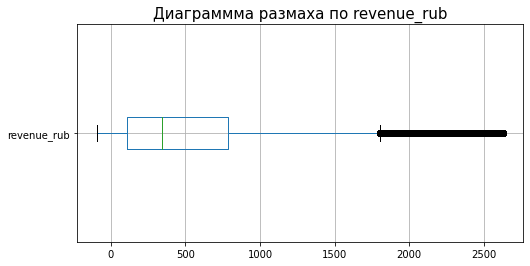

In [23]:
# Построим диаграмму с фильтром по 99 процентилю 
df[df['revenue_rub'] < df['revenue_rub'].quantile(0.99)].boxplot(column='revenue_rub', vert=False, grid=True, figsize=(8, 4))
plt.title('Диаграммма размаха по revenue_rub', size=15)

Text(0.5, 0, 'revenue_rub')

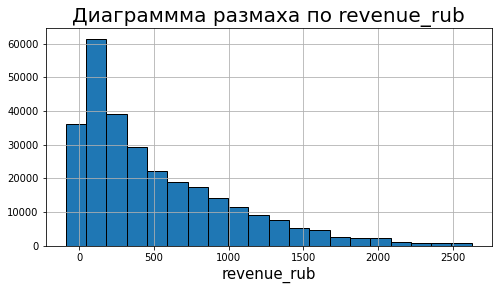

In [24]:
# Построим гстограмму с фильтром по 99 процентилю 
df[df['revenue_rub'] < df['revenue_rub'].quantile(0.99)].hist(column='revenue_rub', bins=20, grid=True, figsize=(8, 4), 
                                                             edgecolor='k')
plt.title('Диаграммма размаха по revenue_rub', size=20)
plt.xlabel('revenue_rub', size=15)

Заметим, что распределение имеет ярко выраженный правй хвост, что говорит о положительной ассиметрии. большинство значений лежат в диапазоне от 0 до 500

Text(0.5, 1.0, 'Диаграммма размаха по tickets_count')

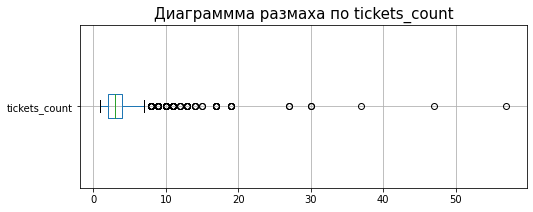

In [25]:
# Посмотрим распредение данных в столбце tickets_count
df.boxplot(column='tickets_count', vert=False, grid=True, figsize=(8, 3))
plt.title('Диаграммма размаха по tickets_count', size=15)

Заметим что в данных присутствует большое количество выбросов, это мешает анализу разброса.
Рассмотрим распределеине без учета выбросов

Text(0.5, 1.0, 'Диаграммма размаха по tickets_count')

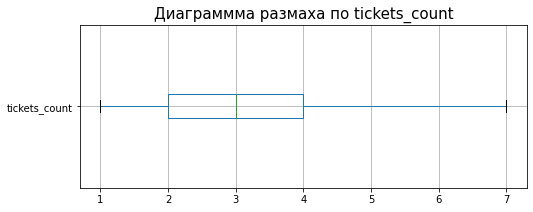

In [26]:
# Посмотрим распредение данных в столбце tickets_count без учета выбросов 
df.boxplot(column='tickets_count', vert=False, grid=True, figsize=(8, 3), showfliers=False)
plt.title('Диаграммма размаха по tickets_count', size=15)

Заметим, что в большинстве заказов покупается от 2 до 4 билетов, посмотрим на распределение значений от 1 до 7

Text(0.5, 0, 'tickets_count')

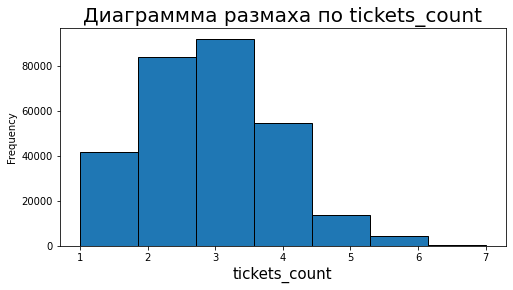

In [27]:
# Построим гистограмму для tickets_count
df[df['tickets_count'] <= 7]['tickets_count'].plot(kind='hist', figsize=(8, 4), edgecolor='k', bins=7)
plt.title('Диаграммма размаха по tickets_count', size=20)
plt.xlabel('tickets_count', size=15)

На гистограмме видно, что практически во всех заказах от 1 до 6 билетов

In [28]:
# Изучим значения в days_since_prev
df[df['days_since_prev'] > -1]['days_since_prev'].describe() # Отберем данные без учета первых заказов

count    268678.000000
mean          3.222381
std          11.350509
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         148.000000
Name: days_since_prev, dtype: float64

Заметим очень высокий максимум, для среднего 3.2 и стандартного отклонения 11.3 
Очевидно в данных есть положительные выбросы.

<AxesSubplot:>

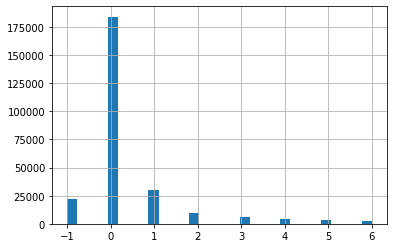

In [29]:
# визуализируем данные из days_since_prev, отсортировав по 90му процентилю
df[df['days_since_prev'] <= df['days_since_prev'].quantile(0.90)]['days_since_prev'].hist(bins=30)

Большинство повторных заказов были сделаны в тот же день, что и предыдущий, другая большая часть заказов была сделана через день.

##### Промежуточный вывод

- Мы создали новый столбец `revenue_rub`, содержащий информацию о цене заказах в рублях 

- Преобразовали типы данных в столбцах:
  
    - `device_type_canonical` : `object` $\rightarrow$ `category` 
     
    - `currency_code` : `object` $\rightarrow$ `category`
    
    - `tickets_count` : `int64` $\rightarrow$ `int8`
    
    - `days_since_prev` : `float64` $\rightarrow$ `int32`
  
  
- Изучили значения в категориальных столбцах:

    - `device_type_canonical`: mobile, desctop
    
    - `currency_code`: rub, kzt
    
    - `event_type_main`: театр, выставки, другое, стендап, концерты, спорт, ёлки


- Количество уникальных значений в столбцах с названиями:

    - `service_name`: 36
    
    - `region_name`: 81
    
    - `city_name`: 352
    
   
- Проверили распредление численных данных и наличие в них выбросов:

    - В столбце `revenue_rub` присутствует большое количество положительных выбросов. Большинство значений лежит в промежутке от 0 до 2000, однако максимальное значение превышает 80 тыс.
    
    - В столбце `tickets_count` также присутствуют выбросы. Большинство заказов содержат 1-6 билетов, однако максимальное значение превышает 50
    
    - В столбце `days_since_prev` большинство заказов были сделаны в тот же день что и предыдущий, а верхний квартиль равен единице, однако максимальное значение равное 148 свидетельствует  сильном правом хвосте.
    

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [30]:
# Датафрейм с информацией по первому заказу пользователя
user_first_order = df[(df['days_since_prev'] == -1)][['user_id', 'created_dt_msk', 'device_type_canonical', 'region_name', 
                                                'service_name', 'event_type_main']].set_index('user_id')

user_first_order.rename(columns={'created_dt_msk': 'first_date'}, inplace=True)

agg_method = {'created_dt_msk': 'max', 'order_id': 'count', 'revenue_rub': 'mean', 'tickets_count': 'mean', 
           'days_since_prev': 'mean'}

# Датафрейм с агрегированными показателями пользователя 
user_group = df.groupby('user_id').agg(agg_method)
user_group.rename(columns={'created_dt_msk': 'last_date'}, inplace=True)
# Объединяем таблицы в одну
user_profile = user_first_order.merge(user_group, on='user_id')

# Выведем первые 5 строк анкеты
user_profile.reset_index(inplace=True) # Уберем поле user_id из индекса для дальнейшей работы
user_profile.columns = ['user_id', 'first_date', 'first_device_type', 'first_region_name', 'first_service_name', 
'first_event_type', 'last_date', 'cnt_orders', 'mean_revenue_rub', 'tickets_mean', 'days_mean']
user_profile.head()

,user_id,first_date,first_device_type,first_region_name,first_service_name,first_event_type,last_date,cnt_orders,mean_revenue_rub,tickets_mean,days_mean
0,0002849b70a3ce2,2024-08-20,mobile,Каменевский регион,Край билетов,театр,2024-08-20,1,1521.940000,4.000000,-1.000000
1,0005ca5e93f2cf4,2024-07-23,mobile,Каменевский регион,Мой билет,выставки,2024-10-06,2,774.010000,3.000000,37.000000
2,000898990054619,2024-07-13,mobile,Североярская область,Лови билет!,другое,2024-10-23,3,767.213333,2.666667,33.666667
3,00096d1f542ab2b,2024-08-15,desktop,Каменевский регион,Край билетов,театр,2024-08-15,1,917.830000,4.000000,-1.000000
4,000a55a418c128c,2024-09-29,mobile,Поленовский край,Лучшие билеты,театр,2024-10-15,2,61.310000,1.500000,7.500000


In [31]:
# Создадим столбец is_two
user_orders = df.groupby('user_id')['order_id'].nunique()
user_profile['is_two'] = user_profile['user_id'].map(user_orders).apply(lambda x: 1 if x >= 2 else 0)

In [32]:
# Создадим столбец is_five
user_orders = df.groupby('user_id')['order_id'].nunique()
user_profile['is_five'] = user_profile['user_id'].map(user_orders).apply(lambda x: 1 if x >= 5 else 0)

# Проверим наличие новых столбцов 
user_profile[['user_id', 'is_two', 'is_five']].head()

,user_id,is_two,is_five
0,0002849b70a3ce2,0,0
1,0005ca5e93f2cf4,1,0
2,000898990054619,1,0
3,00096d1f542ab2b,0,0
4,000a55a418c128c,1,0


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [33]:
# Пользуясь анкетой рассчитаем показатели user_profile

sum_revenue = sum(user_profile['cnt_orders'] * user_profile['mean_revenue_rub'])


print(f'''Общее число пользователей: {user_profile.shape[0]}
Средяя выручка с одного заказа: {round(sum_revenue / sum(user_profile['cnt_orders']), 2)}
Доля пользователей, совершивших 2 и более заказа: {round(user_profile['is_two'].mean(), 2)}
Доля пользователей, совершивших 5 и более заказов: {round(user_profile['is_five'].mean(), 2)}''')

Общее число пользователей: 21933
Средяя выручка с одного заказа: 555.57
Доля пользователей, совершивших 2 и более заказа: 0.62
Доля пользователей, совершивших 5 и более заказов: 0.29


In [34]:
# Изучим статистические показатели 

user_profile[['cnt_orders', 'tickets_mean', 'days_mean']].describe()

,cnt_orders,tickets_mean,days_mean
count,21933.000000,21933.000000,21933.000000
mean,13.249943,2.755987,5.961859
std,122.470535,0.920739,11.080418
min,1.000000,1.000000,-1.000000
25%,1.000000,2.000000,-1.000000
50%,2.000000,2.764151,-0.166667
75%,5.000000,3.125000,9.200000
max,10251.000000,12.000000,73.500000


- В столбце `cnt_orders` присутствуют аномально выское значения, при верхнем квартиле равном 5, стандартное отклонение равно 122, а максимум 10251. Отфильтруем значения по 95 процентилю

- В столбце `tickets_mean` нет значений, похожий на аномальные.

- В столбце `days_mean` высокий максимум, но он не нуждается в фильрации и обусловлен 

In [35]:
user_profile = user_profile[user_profile['cnt_orders'] <= user_profile['cnt_orders'].quantile(0.95)]
user_profile.describe()

,cnt_orders,mean_revenue_rub,tickets_mean,days_mean,is_two,is_five
count,20864.000000,20864.000000,20864.000000,20864.000000,20864.000000,20864.000000
mean,4.108081,575.920150,2.756520,6.161730,0.598639,0.255512
std,5.239384,569.276774,0.941957,11.321338,0.490186,0.436159
min,1.000000,-10.770000,1.000000,-1.000000,0.000000,0.000000
25%,1.000000,204.980000,2.000000,-1.000000,0.000000,0.000000
50%,2.000000,465.379038,2.777778,-0.333333,1.000000,0.000000
75%,5.000000,798.905313,3.187500,9.800000,1.000000,1.000000
max,32.000000,16738.696667,12.000000,73.500000,1.000000,1.000000


После фильтрации по 95му процентилю из 21933 значений осталось 20864, максимум с 10251 снизился до 32, а стандартное отклонение со 122.4 до 5.2

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


Text(0, 0.5, 'кол-во пользователей')

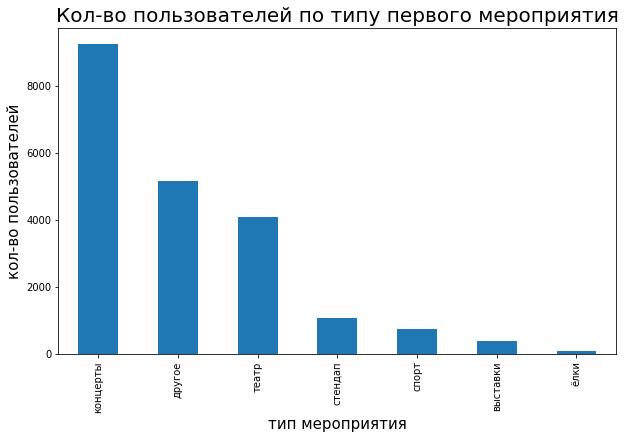

In [36]:
# Сгруппируем пользователей по типу мероприятия
group_event_type = user_profile.groupby('first_event_type')

# Посмотрим кол-во пользователей по сегментам а так же отобразим их долю припопомщи визуализации
group_event_type['user_id'].count().sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Кол-во пользователей по типу первого мероприятия', size=20)
plt.xlabel('тип мероприятия', size=15)
plt.ylabel('кол-во пользователей', size=15)

Больше всего пользователей впервые посетили мероприятие, одного из следующих типов: 
- Концерт - более 8 тыс.
- Другое - около 5 тыс.
- театр - около 4 тыс.

Text(0, 0.5, 'кол-во пользователей')

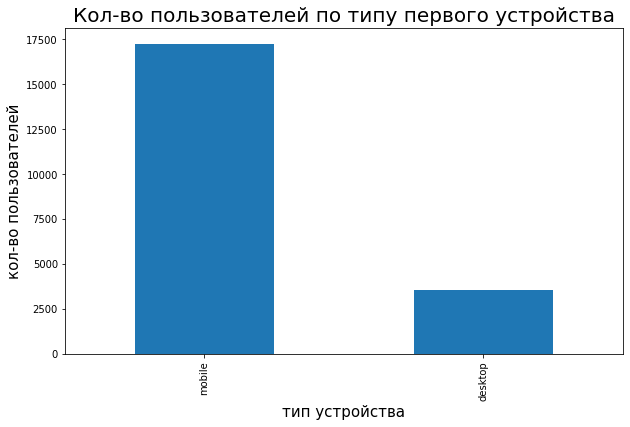

In [37]:
# Сгруппируем пользователей по типу устройства 
group_event_type = user_profile.groupby('first_device_type')

# Посмотрим кол-во пользователей по сегментам а так же отобразим их долю припопомщи визуализации
group_event_type['user_id'].count().sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Кол-во пользователей по типу первого устройства', size=20)
plt.xlabel('тип устройства', size=15)
plt.ylabel('кол-во пользователей', size=15)

Большинство первых заказов сделаны с мобильного телефон - 16 тыс.

Text(0, 0.5, 'кол-во пользователей')

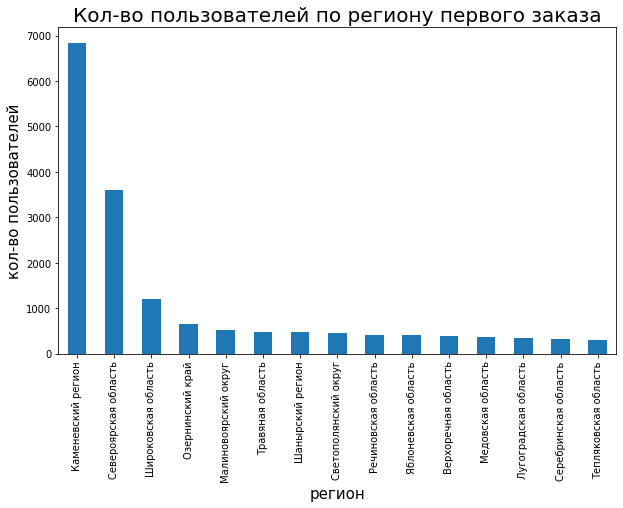

In [38]:
# Сгруппируем пользователей по региону 
group_event_type = user_profile.groupby('first_region_name')

# Посмотрим кол-во пользователей по сегментам а так же отобразим их долю припопомщи визуализации
group_event_type['user_id'].count().sort_values(ascending=False).iloc[:15].plot(kind='bar', figsize=(10, 6))
plt.title('Кол-во пользователей по региону первого заказа', size=20)
plt.xlabel('регион', size=15)
plt.ylabel('кол-во пользователей', size=15)

Большинство первых заказов сделаны с регионов:
- Каменевский регион - более 6 тыс.
- Североярская область - около 3.5 тыс.
- Широковская область - более 1 тыс.

Text(0, 0.5, 'кол-во пользователей')

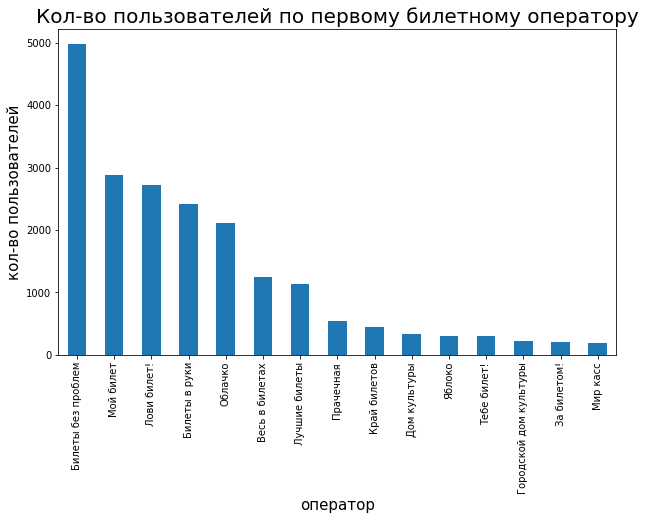

In [39]:
# Сгруппируем пользователей по билетному оператору 
group_event_type = user_profile.groupby('first_service_name')

# Посмотрим кол-во пользователей по сегментам а так же отобразим их долю припопомщи визуализации
group_event_type['user_id'].count().sort_values(ascending=False).iloc[:15].plot(kind='bar', figsize=(10, 6))
plt.title('Кол-во пользователей по первому билетному оператору', size=20)
plt.xlabel('оператор', size=15)
plt.ylabel('кол-во пользователей', size=15)

Большинство первых заказов сделаны у операторов:

- Билеты без проблем - более 4 тыс.
- Мой билет - около 3 тыс.
- Лови билет! - около 2.5 тыс.
- Билеты в руки - около 2.5 тыс.
- Облачко - около 2 тыс.
- Весь в билетах - более 1 тыс.
- Лучшие билеты - более 1 тыс.

Во всех случаях пользователи распределены не равномерно, по каждому признаку видны "точки входа"

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [40]:
# Напишем функцию для подсчета конверсии и ее визуализации
def conv(value, m=None):
    users = user_profile.groupby(value)['user_id'].count() 
    users_is_two = user_profile[user_profile['is_two']==1].groupby(value)['user_id'].count()
    convers = users_is_two / users * 100
    return convers.sort_values(ascending=False).iloc[:m].plot(kind='bar', figsize=(8, 4))

Text(0, 0.5, 'Конверсия, %')

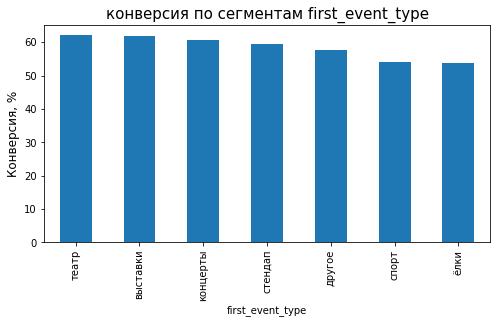

In [41]:
# строим визуализации по сегментам столбца
conv('first_event_type')
plt.title('конверсия по сегментам first_event_type', size=15)
plt.ylabel('Конверсия, %', size=12)

Text(0, 0.5, 'Конверсия, %')

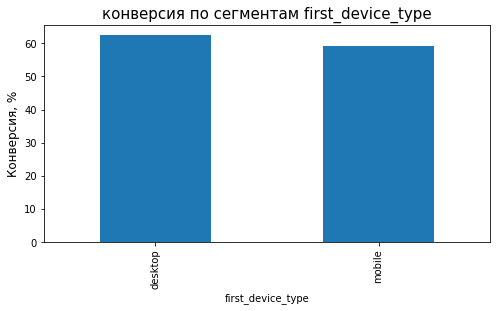

In [42]:
# строим визуализации по сегментам столбца
conv('first_device_type')
plt.title('конверсия по сегментам first_device_type', size=15)
plt.ylabel('Конверсия, %', size=12)

Text(0, 0.5, 'Конверсия, %')

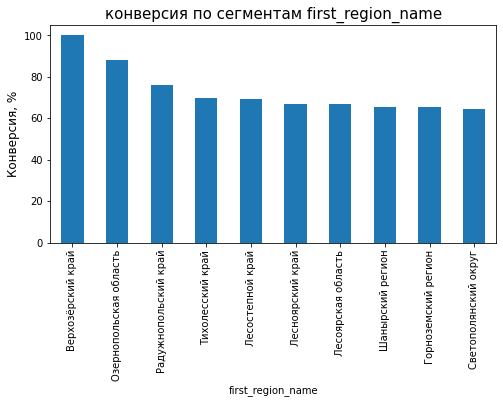

In [43]:
# строим визуализации по сегментам столбца
conv('first_region_name', 10)
plt.title('конверсия по сегментам first_region_name', size=15)
plt.ylabel('Конверсия, %', size=12)

Text(0, 0.5, 'Конверсия, %')

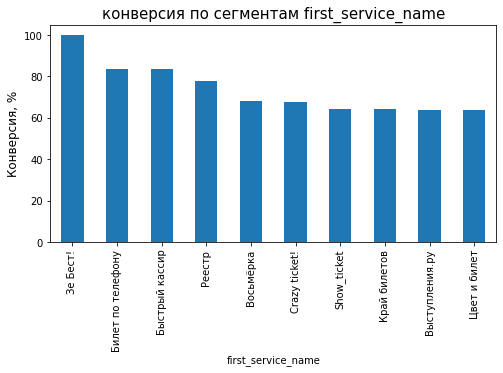

In [44]:
# строим визуализации по сегментам столбца
conv('first_service_name', 10)
plt.title('конверсия по сегментам first_service_name', size=15)
plt.ylabel('Конверсия, %', size=12)

По графикам видно, что коверсия не сильно зависит от сегментации, однако среди регионов и сервисов есть сегменты с конверсией, стремящейся к 100%: сервис Зе Бест! и Верхозерский край. Это может быть связано с малым числом пользователей по сегменту в целом.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

Гипотеза 1
Некорректно сравнивать показатели тк на концерт приходило примерно в 9 раз больше пользователей чем на спортивные мероприятия, однако если смотреть на конверсию, то в случае концертов она больше, чем в случае спортивных мероприятий, таким образом мы можем говорить о том, что первая гипотеза не имеет обоснованного подтверждения

Гипотеза 2
Большинство первых заказов сделаны с регионов: Каменевский регион, Североярская область, Широковская область. Эти регионы не входят в топ 10 по величине конверсии пользователей в пользователей, совершивших 2 и более покупки, таким образом вторая гипотеза не подтвердилась 

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


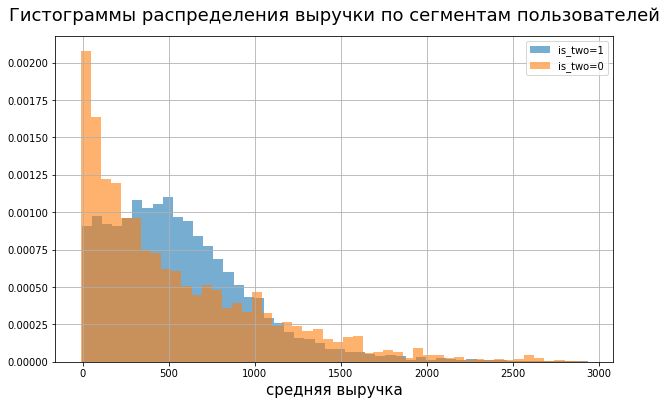

In [45]:
plt.figure(figsize=(10, 6))
plt.hist(user_profile[user_profile['is_two']==1]['mean_revenue_rub'][user_profile['mean_revenue_rub'] < 3000], 
         bins=50, alpha=0.6, density=True, label='is_two=1')
plt.hist(user_profile[user_profile['is_two']==0]['mean_revenue_rub'][user_profile['mean_revenue_rub'] < 3000], 
         bins=50, alpha=0.6, density=True, label='is_two=0')
# часть выбросов мы урезали параметром user_profile['mean_revenue_rub'] < 3000 для более наглядного отображения
plt.title('Гистограммы распределения выручки по сегментам пользователей', size=18, pad=15)
plt.xlabel('средняя выручка', size=15)
plt.grid()
plt.legend()
plt.show()

Между группами присутствует различие. Среди пользователей, не совершивших повторный заказ наблюдается резкий скачок кол-ва значений в интервале от 0 до ~200, среди тех, кто совершил повторыный заказ, данные распределены более равномерно, наблюдается большее кол-во значений в диапазоне от 200 до 1000

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


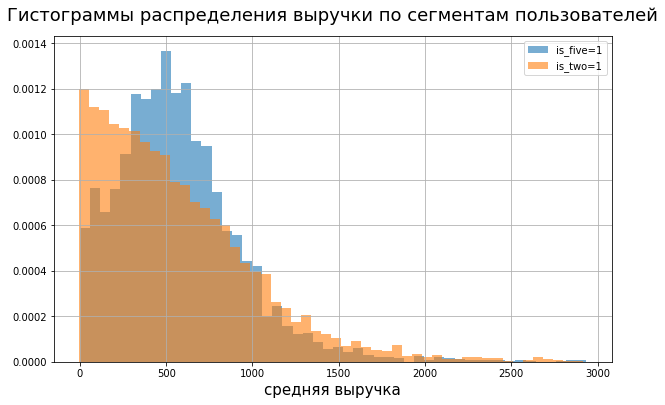

In [59]:
plt.figure(figsize=(10, 6))
plt.hist(user_profile[user_profile['is_five']==1]['mean_revenue_rub'][user_profile['mean_revenue_rub'] < 3000], 
         bins=50, alpha=0.6, density=True, label='is_five=1')
plt.hist(user_profile[(user_profile['is_five']==0)
                     & user_profile['is_two']==1]['mean_revenue_rub'][user_profile['mean_revenue_rub'] < 3000], 
         bins=50, alpha=0.6, density=True, label='is_two=1')
# часть выбросов мы урезали параметром user_profile['mean_revenue_rub'] < 3000 для более наглядного отображения
plt.title('Гистограммы распределения выручки по сегментам пользователей', size=18, pad=15)
plt.xlabel('средняя выручка', size=15)
plt.grid()
plt.legend()
plt.show()

Среди представленных групп есть различия по средней выручке: разница аналогична сравнения групп по признаку `is_two`:
Распределения значений is_five=1 ближе к нормальному, мода приблизительно равно 500, в случае же с is_five=0 клиентами мода находится в значениях близких к нулю

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

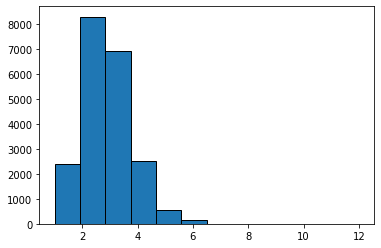

In [47]:
# Изучим распределение пользователей по среднему количеству билетов в заказе
plt.hist(user_profile['tickets_mean'], bins=12, edgecolor='k')
plt.show()

Среднее кол-во билетов имеет нормальное распределение, большинство значений лежат в диапазоне 2-4

In [48]:
# Разделим пользователей на сегменты 
bins = [1, 2, 3, 5, user_profile['tickets_mean'].max()+1]
labels = ['1-2 билета', '2-3 билета', '3-5 билетов', '5+ билетов']
user_profile['tickets_category'] = pd.cut(user_profile['tickets_mean'], bins=bins, labels=labels, include_lowest=True)

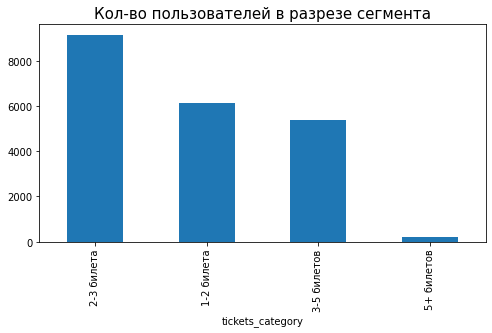

In [49]:
# общее число пользователей по сегментам 
user_profile.groupby('tickets_category')['user_id'].count().sort_values(ascending=False).plot(kind='bar', figsize=(8, 4))
plt.title('Кол-во пользователей в разрезе сегмента', size=15)
plt.show()

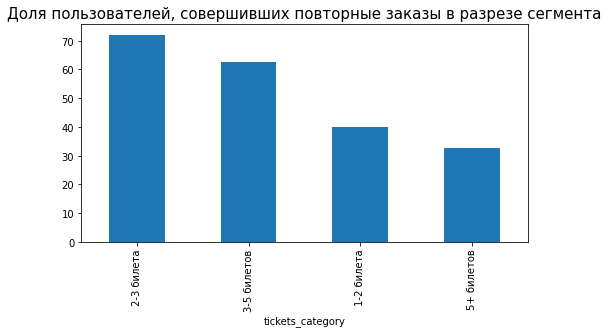

In [50]:
# Доля пользователей, совершивших повторные заказы в разрезе сегмента
conv('tickets_category') # Воспользуемся ранее написанной функцией
plt.title('Доля пользователей, совершивших повторные заказы в разрезе сегмента', size=15)
plt.show()

Пользователи распределены по сегментам не равномерно, большинство пользователей в среднем покупали 2-3 билета, тех кто брал 5 и более билетов сильно меньше.

Сегменты с аномально высокой или низкой долей повторных покупок отсутствуют, все значения лежат в диапазоне 40-70%

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


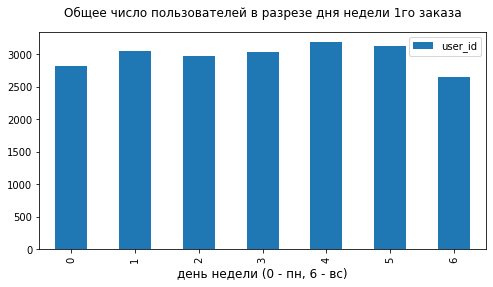

In [51]:
# Общее число пользователей в разрезе дня недели 1го заказа 
user_profile['first_dow'] = user_profile['first_date'].dt.dayofweek
user_profile.groupby('first_dow')['user_id'].count().reset_index().sort_values(by='first_dow').set_index('first_dow').plot(
kind='bar', figsize=(8, 4))
plt.title('Общее число пользователей в разрезе дня недели 1го заказа', pad=15)
plt.xlabel('день недели (0 - пн, 6 - вс)', size=12)
plt.show()

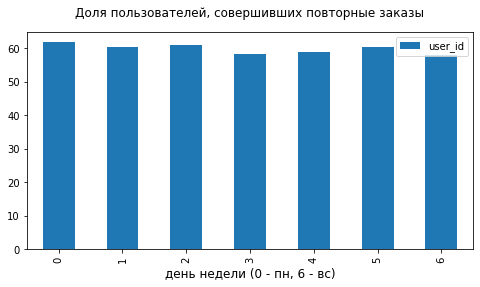

In [52]:
# Доля пользователей, совершивших повторные заказы
users = user_profile.groupby('first_dow')['user_id'].count() 
users_is_two = user_profile[user_profile['is_two']==1].groupby('first_dow')['user_id'].count()
convers = users_is_two / users * 100
convers.reset_index().sort_values(by='first_dow').set_index('first_dow').plot(kind='bar', figsize=(8, 4))

plt.title('Доля пользователей, совершивших повторные заказы', pad=15)
plt.xlabel('день недели (0 - пн, 6 - вс)', size=12)
plt.show()

Основываясь на полученных данных, можем сделать вывод, что день недели не влияет на вероятность возврата клиента

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [53]:
bins = [1, 2, 5, user_profile['cnt_orders'].max()+1]
labels = ['1 заказ', '2-4 заказа', '5+ заказов']
user_profile['order_category'] = pd.cut(user_profile['cnt_orders'], bins=bins, labels=labels, include_lowest=True)

def avg_days_between(cond):
    sum_days = sum(user_profile[cond]['days_mean']*(user_profile[cond]['cnt_orders']-1))
    count_intervals = sum(user_profile[cond]['cnt_orders'])-user_profile[cond]['user_id'].count()
    return round(sum_days / count_intervals, 2)

cond1 = user_profile['order_category']=='2-4 заказа'
cond2 = user_profile['order_category']=='5+ заказов'

print(f'''Среднее время между заказами пользователей, совершивших 2-4 заказа: {avg_days_between(cond1)}
Среднее время между заказами пользователей, совершивших 5 и более заказов: {avg_days_between(cond2)}''')

Среднее время между заказами пользователей, совершивших 2-4 заказа: 12.36
Среднее время между заказами пользователей, совершивших 5 и более заказов: 7.58


Text(0, 0.5, 'среднее кол-во дней между заказами')

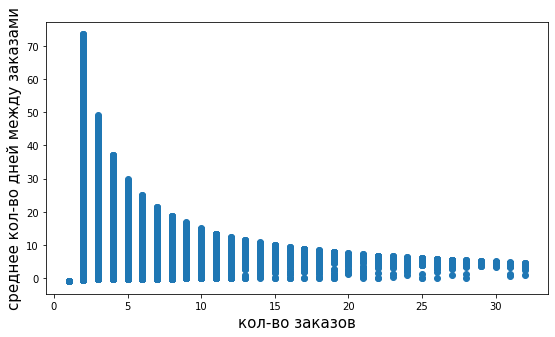

In [54]:
plt.figure(figsize=(9, 5))
plt.scatter(user_profile['cnt_orders'], user_profile['days_mean'])
plt.xlabel('кол-во заказов', size=15)
plt.ylabel('среднее кол-во дней между заказами', size=15)

По графику можно заметить обратную корреляцию между кол-вом заказов и кол-вом дней между ними: чем больше заказов, тем меньше интервал 

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [55]:
user_profile[user_profile.columns.to_list()].phik_matrix()['cnt_orders'].sort_values(ascending=False)

interval columns not set, guessing: ['cnt_orders', 'mean_revenue_rub', 'tickets_mean', 'days_mean', 'is_two', 'is_five', 'first_dow']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable user_id is large: 20864. Are you sure this is not an interval variable? Analysis for pairs of variables including user_id can be slow.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/bivariate.py:255: UserWarning: Many cells: 3192192. Are interval variables set correctly?
  warnings.warn(


user_id               1.000000
cnt_orders            1.000000
is_five               1.000000
order_category        0.790713
is_two                0.618740
days_mean             0.595388
last_date             0.393659
first_date            0.388742
tickets_mean          0.314573
tickets_category      0.259539
mean_revenue_rub      0.047313
first_device_type     0.042641
first_service_name    0.036429
first_event_type      0.026103
first_dow             0.021037
first_region_name     0.000000
Name: cnt_orders, dtype: float64

In [56]:
# Посмотрим корреляцию по категориям 
matrix = user_profile[['first_region_name', 'first_event_type', 'mean_revenue_rub', 'tickets_mean', 'first_date', 'last_date', 
'days_mean', 'order_category',
'first_service_name', 'first_device_type']].phik_matrix()[['order_category']].sort_values(by='order_category', ascending=False)
matrix

interval columns not set, guessing: ['mean_revenue_rub', 'tickets_mean', 'days_mean']


,order_category
order_category,1.000000
days_mean,0.618888
last_date,0.557437
first_date,0.527666
tickets_mean,0.374549
first_region_name,0.098883
mean_revenue_rub,0.073651
first_service_name,0.068286
first_event_type,0.025861
first_device_type,0.017124


<AxesSubplot:>

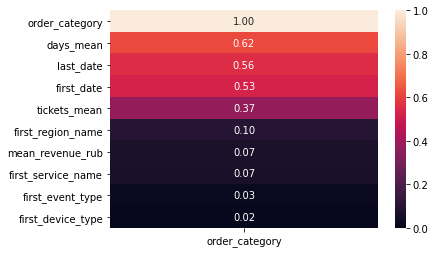

In [57]:
# строим тепловую карту
sns.heatmap(matrix, annot=True, vmin=0, vmax=1, fmt='.2f')

С кол-вом заказов наиболее сильно коррелируют атрибуты `days_mean`, `last_date` и `first_date`

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

## Вывод

- В рамках исследования мы поработали с базой данных data-analyst-afisha, содержащей информацию о покупках билотов на платформе яндекс афиша. Мы составили подзапрос sql, содержащий необходимую информацию и продолжили работу с ним в jupyterhub.

- В ходе предобработки данных мы создали столбец `revenue_rub` содержащий информацию о стоимости заказа в рублях
- Также оптимизировали типы данных, изучили категориальные значения, кол-во городов, регионов и сервисов
- Создали профиль пользователя для дальнейшей работы

Основные результаты анализа 
- В выборке представлены 21933 пользователя, 75% пользователей совершили менее 6 заказов, при этом макимальное число заказов достигает 10251, в среднем каждый заказ включает 2-3 билета.

- Чаще всего возвращаются пользователи купишвие билеты в Верхозёрском крае и Озернопольской области, также те, кто покупал билеты на сервисах Зе бест!, Билет по телефону и Быстрый кассир. Это может быть связано с малым числом пользователей в данных сегментах 

- Средняя выручка для клиентов совершивших повторные заказы больше, наибольшую конверсию в повторный заказ имеют пользователи, покупающие 2-3 билета, а наименьшую те, кто берут больше 5

- День недели не влияет на удержание пользовате

- большинство билетов куплены у Билеты без проблем

- Чаще всего первый билет покупают на концерт

В качетсве рекомендации можем посоветовать обратить внимание на популярность концертов, около 9000 пользователей впервые купили билет на концерт и около 60% сделала повторный заказ

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**